# Economics Tie-In

It's considered general knowledge that the worse state the economy/country is in, the better the entertainment industry does. But is this true? Can we see any sort of relationship between the state of the film industry and the standings of average means in the US?

To find out, we will be using two datasets (one for average wages by metric, and one for unemployment rates by metric) to create one economic DataFrame (DF) from which we can draw our comparrisons.

In [1]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Data

---

The following datasets are courtesy of __[Kaggle](https://www.kaggle.com/)__.

### __['...CCI_OECD.csv'](https://www.kaggle.com/datasets/iqbalsyahakbar/cci-oecd)__

*renamed from `DP_LIVE_16112023095843236.csv`*

Per the Organisation for Economic Co-operation and Development (OECD);

* The Consumer Confidence Indicator (CCI) is an indication of developments for future households' consumption and saving based on expected financial situation, sentiment regarding the general economic situation, employment status, and capacity for savings
* An indicator above `100` indicates an optimistic outlook and a greater likliehood to spend money over cautious saving
* An indicator below `100` indicates a pessimistic outlook and both a higher likeliehood to save money and a lower tendency to consume

### __['...US_inflation_rates.csv'](https://www.kaggle.com/datasets/pavankrishnanarne/us-inflation-dataset-1947-present)__

Per XXX

* XXX

### __['...public_debt.csv'](https://www.kaggle.com/datasets/pavankrishnanarne/us-public-debt-quarterly-data-1996-present)__

Per XXX

* XXX

---

The following datasets are courtesy of the __[Economic Policy Institute’s (EPI) State of Working America Data Library](https://www.epi.org/data/)__.

### __['...Medianaverage hourly wages.csv'](https://www.epi.org/data/#?subject=wage-avg)__

Per EPI description;

* Wages adjusted to 2023 dollars by the Consumer Price Index for All Urban Consumers Research Series
* `Median Wage` is the hourly wage in the middle of the wage distribution
* `Average Wage` is the calculated mean of all wages

### __['...Unemployment.csv'](https://www.epi.org/data/#?subject=unemp)__

Per EPI description;

* Unemployment is the share of the labor force wihout a job
* Monthly percentages calculated as a rolling 12-month average (mean)

In [3]:
# Reading in data
df_hourly_wages = pd.read_csv("./Resources/EPI Data Library - Medianaverage hourly wages.csv")
df_unemp = pd.read_csv("./Resources/EPI Data Library - Unemployment.csv")
df_cci = pd.read_csv("./Resources/CCI_OECD.csv")
df_inflation = pd.read_csv("./Resources/US_inflation_rates.csv")
df_public_debt = pd.read_csv("./Resources/public_debt.csv")

# CCI

#### Preprocessing of the `CCI_OECD.csv` dataset

The

In [4]:
# Viewing `df_cci`
df_cci.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-01,101.4526,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-02,101.4332,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-03,101.2753,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-04,101.0106,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-05,100.8543,NaN


#### Beginning of limited EDA

In [8]:
# Beginning EDA on `df_cci`
df_cci['TIME'].describe()

count       21552
unique        767
top       2012-09
freq           49
Name: TIME, dtype: object

In [9]:
# Continuing EDA
df_cci.dtypes

LOCATION       object
INDICATOR      object
SUBJECT        object
MEASURE        object
FREQUENCY      object
TIME           object
Value         float64
Flag Codes    float64
dtype: object

In [11]:
# Continuing EDA
df_cci['LOCATION'].unique()

array(['NLD', 'CHE', 'FRA', 'POL', 'CZE', 'JPN', 'OECDE', 'AUS', 'OECD',
       'SWE', 'MEX', 'GBR', 'ZAF', 'USA', 'HUN', 'PRT', 'DNK', 'ESP',
       'LUX', 'GRC', 'BRA', 'SVK', 'CHN', 'BEL', 'FIN', 'NZL', 'G-7',
       'IDN', 'TUR', 'AUT', 'ITA', 'IRL', 'SVN', 'DEU', 'KOR', 'EST',
       'EA19', 'ISR', 'RUS', 'LVA', 'LTU', 'G7M', 'OEU', 'COL', 'CHL',
       'CRI', 'IND', 'G-20', 'EU27_2020'], dtype=object)

In [ ]:
# Continuing EDA

In [ ]:
# Continuing EDA

#### Selecting only domestic data

In [12]:
# Selecting uneeded columns from `df_cci`
drop_cols = [
    'LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes'
]

In [19]:
# Copying domestic data from `df_cci` to `df_cci_us` and removing uneeded columns
df_cci_us = df_cci.loc[df_cci['LOCATION'] == 'USA'].drop(columns=drop_cols).reset_index(drop=True).copy()

# Viewing `df_cci_us`
df_cci_us.head()

,TIME,Value
0,1960-01,101.6304
1,1960-02,101.3717
2,1960-03,101.1483
3,1960-04,101.0250
4,1960-05,101.0561


# Inflation

#### Preprocessing of the `US_inflation_rates.csv` dataset

The

In [5]:
# Viewing `df_inflation`
df_inflation.head()

,date,value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


# Public Debt

#### Preprocessing of the `public_debt.csv` dataset

The

In [6]:
# Viewing `df_public_debt`
df_public_debt.head()

,date,value
0,1966-01-01,320999.0
1,1966-04-01,316097.0
2,1966-07-01,324748.0
3,1966-10-01,329319.0
4,1967-01-01,330947.0


## Hourly Wages

#### Preprocessing of the `Medianaverage hourly wages.csv` dataset

The goal here is to prepare the wages DF for concatenation with the unemployment DF. Since this set came with data by year, there is no need for aggregation at this point. Data types need to be confirmed, values need to be formatted, and the index needs to be set as the year.

In [3]:
# Viewing `df_hourly_wages`
df_hourly_wages.head()

,Date,Median,Average,Men Median,Men Average,Women Median,Women Average,White Median,White Average,Black Median,...,Black Women Median,Black Women Average,Hispanic Women Median,Hispanic Women Average,Recent high-school graduate,Men Recent high-school graduate,Women Recent high-school graduate,Recent college graduate,Men Recent college graduate,Women Recent college graduate
0,2023,$23.75,$33.50,$25.06,$36.98,$21.80,$29.74,$25.97,$36.09,$20.11,...,$19.93,$25.59,$18.30,$23.60,$16.16,$17.11,$14.76,$25.93,$28.59,$24.01
1,2022,$23.31,$33.31,$25.29,$37.29,$21.08,$29.00,$25.96,$35.90,$20.39,...,$19.75,$24.98,$18.28,$23.53,$16.48,$17.47,$15.00,$25.14,$27.48,$23.41
2,2021,$23.74,$33.43,$25.92,$37.11,$21.85,$29.46,$26.49,$35.94,$20.26,...,$19.69,$25.14,$18.48,$23.86,$15.87,$16.46,$15.02,$26.10,$28.97,$24.03
3,2020,$24.09,$33.95,$26.56,$37.60,$22.53,$30.01,$27.22,$36.38,$20.79,...,$20.05,$25.95,$18.29,$24.03,$15.29,$16.11,$14.11,$27.38,$28.68,$26.46
4,2019,$22.94,$31.71,$24.75,$35.14,$21.01,$28.02,$25.49,$34.24,$19.19,...,$18.88,$24.20,$17.92,$22.45,$15.34,$16.21,$14.08,$24.97,$27.08,$23.46


#### Beginning of limited EDA

In [4]:
# Beginning EDA on `df_hourly_wages`
df_hourly_wages['Date'].describe()

count      51.000000
mean     1998.000000
std        14.866069
min      1973.000000
25%      1985.500000
50%      1998.000000
75%      2010.500000
max      2023.000000
Name: Date, dtype: float64

In [5]:
# Continuing EDA
df_hourly_wages['Date'].dtype

dtype('int64')

In [6]:
# Continuing EDA
df_hourly_wages.shape

(51, 31)

In [7]:
# Continuing EDA
display(df_hourly_wages['Date'].head(3))
display(df_hourly_wages['Date'].tail(3))

0    2023
1    2022
2    2021
Name: Date, dtype: int64

48    1975
49    1974
50    1973
Name: Date, dtype: int64

#### Data Conversion

In [8]:
# Creating a list of columns to strip and convert
dollar_cols = df_hourly_wages.drop(columns='Date').columns.to_list()

# Confirming columns
dollar_cols

['Median',
 'Average',
 'Men Median',
 'Men Average',
 'Women Median',
 'Women Average',
 'White Median',
 'White Average',
 'Black Median',
 'Black Average',
 'Hispanic Median',
 'Hispanic Average',
 'White Men Median',
 'White Men Average',
 'Black Men Median',
 'Black Men Average',
 'Hispanic Men Median',
 'Hispanic Men Average',
 'White Women Median',
 'White Women Average',
 'Black Women Median',
 'Black Women Average',
 'Hispanic Women Median',
 'Hispanic Women Average',
 'Recent high-school graduate',
 'Men Recent high-school graduate',
 'Women Recent high-school graduate',
 'Recent college graduate',
 'Men Recent college graduate',
 'Women Recent college graduate']

In [9]:
# Verifying dtype of columns in `dollar_cols` before proceeding
df_hourly_wages[dollar_cols].dtypes

Median                               object
Average                              object
Men Median                           object
Men Average                          object
Women Median                         object
Women Average                        object
White Median                         object
White Average                        object
Black Median                         object
Black Average                        object
Hispanic Median                      object
Hispanic Average                     object
White Men Median                     object
White Men Average                    object
Black Men Median                     object
Black Men Average                    object
Hispanic Men Median                  object
Hispanic Men Average                 object
White Women Median                   object
White Women Average                  object
Black Women Median                   object
Black Women Average                  object
Hispanic Women Median           

In [11]:
# Defining a function to remove '$' and convert data to numeric
def convert_dollars(val):
    if isinstance(val, str):
        return float(val.strip('$'))
    return val

# Applying function to `agg_cols` in `df_unemp`
for col in df_hourly_wages[dollar_cols].columns:
    try:
        df_hourly_wages[col] = df_hourly_wages[col].apply(convert_dollars)
    except ValueError:
        print(f'Column {col} could not be converted, please verify dtype')

# Confirming conversion
df_hourly_wages[dollar_cols].dtypes

Median                               float64
Average                              float64
Men Median                           float64
Men Average                          float64
Women Median                         float64
Women Average                        float64
White Median                         float64
White Average                        float64
Black Median                         float64
Black Average                        float64
Hispanic Median                      float64
Hispanic Average                     float64
White Men Median                     float64
White Men Average                    float64
Black Men Median                     float64
Black Men Average                    float64
Hispanic Men Median                  float64
Hispanic Men Average                 float64
White Women Median                   float64
White Women Average                  float64
Black Women Median                   float64
Black Women Average                  float64
Hispanic W

In [12]:
# Renaming columns from `dollar_cols` in `df_hourly_wages` for readability after conversion
for col in df_hourly_wages[dollar_cols].columns:
    try:
        new_col = col + ' (USD)'
        df_hourly_wages.rename(columns={col: new_col}, inplace=True)
    except ValueError:
        print(f'Column {col} could not be renamed')

# Confirming renamed correctly
df_hourly_wages.columns

Index(['Date', 'Median (USD)', 'Average (USD)', 'Men Median (USD)',
       'Men Average (USD)', 'Women Median (USD)', 'Women Average (USD)',
       'White Median (USD)', 'White Average (USD)', 'Black Median (USD)',
       'Black Average (USD)', 'Hispanic Median (USD)',
       'Hispanic Average (USD)', 'White Men Median (USD)',
       'White Men Average (USD)', 'Black Men Median (USD)',
       'Black Men Average (USD)', 'Hispanic Men Median (USD)',
       'Hispanic Men Average (USD)', 'White Women Median (USD)',
       'White Women Average (USD)', 'Black Women Median (USD)',
       'Black Women Average (USD)', 'Hispanic Women Median (USD)',
       'Hispanic Women Average (USD)', 'Recent high-school graduate (USD)',
       'Men Recent high-school graduate (USD)',
       'Women Recent high-school graduate (USD)',
       'Recent college graduate (USD)', 'Men Recent college graduate (USD)',
       'Women Recent college graduate (USD)'],
      dtype='object')

## ***RECONSIDER THIS SLICE VVV***

In [14]:
# Converting `df_hourly_wages['Date]` to datetime for later use
# df_hourly_wages['Date'] = pd.to_datetime({
#                               'year': df_hourly_wages['Date'],
#                               'month': 12,
#                               'day': 1,
#                               'hour': 23,
#                               'minute': 59,
#                               'second': 59
#                              })

# # # Confirming conversion
# df_hourly_wages['Date'].head(3)

# I had planned on MAYBE doing some work with Prophet on this data, so I would have
# needed a datetime value? But then I realized after working with the data a bit
# that I need JUST the year to do the final join with `df_hourly_wages` and `df_unemp`. So! I
# decided to comment this out (and a few cells below) to retain the code for if I
# DO wind up needing it. I'll note the other cells I did this in as Retaining as
# they come up.


## ***RECONSIDER THIS SLICE ^^^***

#### Indexing

In [13]:
# Setting 'Date' as the index for `df_hourly_wages`
df_hourly_wages.set_index('Date', inplace=True)

# Reconfirming `df_hourly_wages` ready to concatenate with data from `df_unemp`
df_hourly_wages.head()

,Median (USD),Average (USD),Men Median (USD),Men Average (USD),Women Median (USD),Women Average (USD),White Median (USD),White Average (USD),Black Median (USD),Black Average (USD),...,Black Women Median (USD),Black Women Average (USD),Hispanic Women Median (USD),Hispanic Women Average (USD),Recent high-school graduate (USD),Men Recent high-school graduate (USD),Women Recent high-school graduate (USD),Recent college graduate (USD),Men Recent college graduate (USD),Women Recent college graduate (USD)
Date,,,,,,,,,,,,,,,,,,,,,
2023,23.75,33.50,25.06,36.98,21.80,29.74,25.97,36.09,20.11,27.24,...,19.93,25.59,18.30,23.60,16.16,17.11,14.76,25.93,28.59,24.01
2022,23.31,33.31,25.29,37.29,21.08,29.00,25.96,35.90,20.39,26.66,...,19.75,24.98,18.28,23.53,16.48,17.47,15.00,25.14,27.48,23.41
2021,23.74,33.43,25.92,37.11,21.85,29.46,26.49,35.94,20.26,26.46,...,19.69,25.14,18.48,23.86,15.87,16.46,15.02,26.10,28.97,24.03
2020,24.09,33.95,26.56,37.60,22.53,30.01,27.22,36.38,20.79,27.16,...,20.05,25.95,18.29,24.03,15.29,16.11,14.11,27.38,28.68,26.46
2019,22.94,31.71,24.75,35.14,21.01,28.02,25.49,34.24,19.19,25.16,...,18.88,24.20,17.92,22.45,15.34,16.21,14.08,24.97,27.08,23.46


## Unemployment

#### Preprocessing of the `Unemployment.csv` dataset

With the wages DF set, the unemployment DF needs to be prepared. Data needs to be converted for aggregation, as this dataset came as rolling 12-month averages by month. Annual data will need to be engineered in order to concatenate the two DFs.

In [15]:
# Viewing `df_unemp`
df_unemp.head()

,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
0,Mar-2024,3.7%,3.5%,3.9%,5.8%,4.6%,3.0%,5.5%,6.2%,4.6%,...,2.9%,8.0%,3.2%,2.6%,3.0%,2.0%,2.5%,5.0%,7.7%,3.4%
1,Feb-2024,3.7%,3.5%,3.8%,5.7%,4.6%,3.0%,5.4%,6.0%,4.6%,...,2.9%,7.9%,3.2%,2.6%,2.9%,1.9%,2.5%,5.0%,7.5%,3.4%
2,Jan-2024,3.7%,3.5%,3.8%,5.7%,4.7%,2.9%,5.4%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.6%,2.9%,1.9%,2.4%,4.9%,7.4%,3.4%
3,Dec-2023,3.6%,3.5%,3.8%,5.7%,4.6%,2.9%,5.5%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.5%,2.8%,1.9%,2.5%,4.9%,7.4%,3.4%
4,Nov-2023,3.6%,3.4%,3.8%,5.7%,4.6%,2.9%,5.6%,5.9%,4.5%,...,2.9%,8.0%,3.1%,2.5%,2.8%,1.9%,2.5%,4.8%,7.3%,3.4%


#### Beginning of limited EDA

In [16]:
# Beginning EDA on `df_unemp`
df_unemp['Date'].describe()

count          544
unique         544
top       Mar-2024
freq             1
Name: Date, dtype: object

In [17]:
# Continuing EDA
df_unemp['Date'].dtype

dtype('O')

In [18]:
# Continuing EDA
df_unemp.shape

(544, 121)

In [19]:
# Continuing EDA
display(df_unemp['Date'].head(3))
display(df_unemp['Date'].tail(3))

0    Mar-2024
1    Feb-2024
2    Jan-2024
Name: Date, dtype: object

541    Feb-1979
542    Jan-1979
543    Dec-1978
Name: Date, dtype: object

## ***RECONSIDER THIS SLICE VVV***

#### Data Conversion

In [20]:
# Slicing a Month value from `df_unemp['Date']`
# df_unemp['Date Month'] = df_unemp['Date'].str.slice(0,3)
# df_unemp['Date Month'].value_counts()

# Same as mentioned above, thought I'd need this for Pophet, but don't need it,
# yet. 
# Retaining.

In [21]:
# Converting sliced Month values to integers
# Creating a dictionary of Months
# month_map = {
#     'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
#     'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
# }

# # Mapping integer values to engineered column
# df_unemp['Date Month'] = df_unemp['Date Month'].map(month_map)

# # Confirming mapped correctly
# df_unemp['Date Month'].value_counts()

# Legit sad I'm not using this right away, this was some COOL code! Ugh...
# Retaining.

## ***RECONSIDER THIS SLICE ^^^***

In [22]:
# Slicing a Year value from `df_unemp['Date']`
df_unemp['Date Year'] = df_unemp['Date'].str.slice(4,8).astype(int)
df_unemp['Date Year'].head(16)

# Actually did still need this one, at least!

0     2024
1     2024
2     2024
3     2023
4     2023
5     2023
6     2023
7     2023
8     2023
9     2023
10    2023
11    2023
12    2023
13    2023
14    2023
15    2022
Name: Date Year, dtype: int32

## ***THIS TOO VVV***

In [23]:
# Converting `df_unemp['Date]` to datetime for later use
# df_unemp['Date'] = pd.to_datetime({
#                               'year': df_unemp['Date Year'],
#                               'month': df_unemp['Date Month'],
#                               'day': 1,
#                               'hour': 23,
#                               'minute': 59,
#                               'second': 59
#                              })

# # Confirming conversion
# df_unemp['Date'].head(3)

# Retaining.

## ***THIS TOO ^^^***

In [24]:
drop_cols = ['Date', 'Date Year']

for col in df_unemp.drop(columns=drop_cols).columns:
    try:
        new_col = col + ' (%)'
        df_unemp.rename(columns={col: new_col}, inplace=True)
    except ValueError:
        print(f'Column {col} could not be renamed')

df_unemp.columns

Index(['Date', 'All (%)', 'Women (%)', 'Men (%)', 'Black (%)', 'Hispanic (%)',
       'White (%)', 'Black Women (%)', 'Black Men (%)', 'Hispanic Women (%)',
       ...
       '16-24 (%)', '25-54 (%)', '55-64 (%)', '65+ (%)', 'Advanced degree (%)',
       'Bachelor's degree (%)', 'High school (%)', 'Less than HS (%)',
       'Some college (%)', 'Date Year'],
      dtype='object', length=122)

# ***REWORK FROM HERE, NO NEED TO AGGREGATE THIS DATA***
## ***VVV***

In [25]:
# Creating a list of columns to aggregate
agg_cols = df_unemp.drop(columns=drop_cols, axis=1).columns.to_list()

# Confirming columns
agg_cols

['All (%)',
 'Women (%)',
 'Men (%)',
 'Black (%)',
 'Hispanic (%)',
 'White (%)',
 'Black Women (%)',
 'Black Men (%)',
 'Hispanic Women (%)',
 'Hispanic Men (%)',
 'White Women (%)',
 'White Men (%)',
 'Black 16-24 (%)',
 'Black 25-54 (%)',
 'Black 55-64 (%)',
 'Black 65+ (%)',
 'Hispanic 16-24 (%)',
 'Hispanic 25-54 (%)',
 'Hispanic 55-64 (%)',
 'Hispanic 65+ (%)',
 'White 16-24 (%)',
 'White 25-54 (%)',
 'White 55-64 (%)',
 'White 65+ (%)',
 'Women 16-24 (%)',
 'Women 25-54 (%)',
 'Women 55-64 (%)',
 'Women 65+ (%)',
 'Men 16-24 (%)',
 'Men 25-54 (%)',
 'Men 55-64 (%)',
 'Men 65+ (%)',
 'Black Women 16-24 (%)',
 'Black Women 25-54 (%)',
 'Black Women 55-64 (%)',
 'Black Women 65+ (%)',
 'Black Men 16-24 (%)',
 'Black Men 25-54 (%)',
 'Black Men 55-64 (%)',
 'Black Men 65+ (%)',
 'Hispanic Women 16-24 (%)',
 'Hispanic Women 25-54 (%)',
 'Hispanic Women 55-64 (%)',
 'Hispanic Women 65+ (%)',
 'Hispanic Men 16-24 (%)',
 'Hispanic Men 25-54 (%)',
 'Hispanic Men 55-64 (%)',
 'Hispanic M

In [26]:
# Verifying dtype of columns in `agg_cols` before aggregating
df_unemp[agg_cols].dtypes

All (%)                  object
Women (%)                object
Men (%)                  object
Black (%)                object
Hispanic (%)             object
                          ...  
Advanced degree (%)      object
Bachelor's degree (%)    object
High school (%)          object
Less than HS (%)         object
Some college (%)         object
Length: 120, dtype: object

In [27]:
# Defining a function to remove '%' and convert data to numeric percentages
def convert_percentage(obj):
    return float(obj.strip('%'))

# Applying function to `agg_cols` in `df_unemp`
for col in df_unemp[agg_cols].columns:
    try:
        df_unemp[col] = df_unemp[col].apply(convert_percentage)
    except ValueError:
        print(f'Column {col} could not be converted, please verify dtype')

# Confirming conversion
df_unemp[agg_cols].dtypes

All (%)                  float64
Women (%)                float64
Men (%)                  float64
Black (%)                float64
Hispanic (%)             float64
                          ...   
Advanced degree (%)      float64
Bachelor's degree (%)    float64
High school (%)          float64
Less than HS (%)         float64
Some college (%)         float64
Length: 120, dtype: object

#### Aggregation

In [28]:
# Aggregating data by `mean()` for each year in 'Date Year'
df_unemp_agg = df_unemp.groupby('Date Year', sort=False)[agg_cols].mean().round(3)

# Confirming aggregated data
df_unemp_agg.head()

,All (%),Women (%),Men (%),Black (%),Hispanic (%),White (%),Black Women (%),Black Men (%),Hispanic Women (%),Hispanic Men (%),...,White Men Some college (%),16-24 (%),25-54 (%),55-64 (%),65+ (%),Advanced degree (%),Bachelor's degree (%),High school (%),Less than HS (%),Some college (%)
Date Year,,,,,,,,,,,,,,,,,,,,,
2024,3.700,3.500,3.833,5.733,4.633,2.967,5.433,6.033,4.600,4.633,...,2.900,7.933,3.167,2.600,2.933,1.933,2.467,4.967,7.533,3.400
2023,3.600,3.500,3.650,5.792,4.433,2.883,5.758,5.858,4.417,4.442,...,2.900,7.942,3.067,2.433,2.808,1.758,2.433,4.817,7.133,3.442
2022,4.225,4.150,4.283,7.108,5.100,3.358,6.825,7.408,5.442,4.808,...,3.533,8.567,3.742,3.117,3.475,1.850,2.883,5.683,7.958,4.250
2021,6.933,6.942,6.917,10.442,8.992,5.517,9.733,11.192,9.550,8.575,...,6.067,12.392,6.267,5.750,6.125,3.292,5.050,8.933,11.700,7.400
2020,5.883,6.067,5.733,8.617,7.392,4.842,8.175,9.092,8.167,6.775,...,4.925,11.808,5.108,4.625,5.292,2.867,4.158,7.483,10.733,6.142


## ***^^^***

# ***NEED TO REDO FROM HERE DOWN***

## Combined Economics

#### Preprocessing of the `df_economics` DF

With both DFs set to annual data with year as the index, the sets can be concatenated into one DF for further processing, visualizations, and modelling.

In [29]:
# Concatenating `df_hourly_wages` with `df_unemp_agg` to create a DF with annual unemployment
# percentages and median/average earnings
df_economics = pd.concat([df_hourly_wages, df_unemp_agg], axis=1, join='inner')

# Confirming concatenation
df_economics

,Median (USD),Average (USD),Men Median (USD),Men Average (USD),Women Median (USD),Women Average (USD),White Median (USD),White Average (USD),Black Median (USD),Black Average (USD),...,White Men Some college (%),16-24 (%),25-54 (%),55-64 (%),65+ (%),Advanced degree (%),Bachelor's degree (%),High school (%),Less than HS (%),Some college (%)
2023,23.75,33.50,25.06,36.98,21.80,29.74,25.97,36.09,20.11,27.24,...,2.900,7.942,3.067,2.433,2.808,1.758,2.433,4.817,7.133,3.442
2022,23.31,33.31,25.29,37.29,21.08,29.00,25.96,35.90,20.39,26.66,...,3.533,8.567,3.742,3.117,3.475,1.850,2.883,5.683,7.958,4.250
2021,23.74,33.43,25.92,37.11,21.85,29.46,26.49,35.94,20.26,26.46,...,6.067,12.392,6.267,5.750,6.125,3.292,5.050,8.933,11.700,7.400
2020,24.09,33.95,26.56,37.60,22.53,30.01,27.22,36.38,20.79,27.16,...,4.925,11.808,5.108,4.625,5.292,2.867,4.158,7.483,10.733,6.142
2019,22.94,31.71,24.75,35.14,21.01,28.02,25.49,34.24,19.19,25.16,...,2.933,8.525,3.150,2.717,3.167,1.950,2.500,4.725,7.942,3.617
2018,22.52,31.16,24.30,34.67,20.54,27.38,25.04,33.88,18.33,24.57,...,3.225,8.883,3.458,3.000,3.358,2.000,2.525,5.267,8.467,3.892
2017,22.46,30.51,24.52,33.71,20.38,27.07,25.00,33.05,18.68,23.97,...,3.767,9.767,3.975,3.267,3.800,2.133,2.842,5.942,9.883,4.333
2016,22.12,30.29,24.35,33.60,20.16,26.71,24.58,32.68,18.89,24.11,...,4.100,10.892,4.258,3.633,3.742,2.217,2.925,6.517,10.408,4.767
2015,21.88,29.69,23.76,32.91,19.66,26.22,24.41,32.11,18.08,23.72,...,4.458,12.367,4.767,4.033,4.258,2.400,3.342,7.025,11.758,5.525
2014,21.27,28.57,23.29,31.41,19.51,25.53,23.71,30.79,17.95,23.15,...,5.442,14.300,5.733,4.808,4.833,2.833,4.033,8.333,13.583,6.592


In [30]:
# Creating a list to confirm no row in `df_economics` have `NaN` values
confirm_not_NaN = df_economics.count().isna().to_list()

# Confirming no `NaN` values
confirm_not_NaN

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


#### Indexing

In [31]:
# Resetting index for `df_economics`
df_economics.reset_index(inplace=True)

# Renaming previous index to 'Year'
df_economics.rename(columns={'index': 'Year'}, inplace=True)

# Confirming index and first and last years covered by data
display(df_economics.head())
display(df_economics.tail())

C:\Users\joblu\AppData\Local\Temp\ipykernel_51084\1110468109.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_economics.reset_index(inplace=True)


,Year,Median (USD),Average (USD),Men Median (USD),Men Average (USD),Women Median (USD),Women Average (USD),White Median (USD),White Average (USD),Black Median (USD),...,White Men Some college (%),16-24 (%),25-54 (%),55-64 (%),65+ (%),Advanced degree (%),Bachelor's degree (%),High school (%),Less than HS (%),Some college (%)
0,2023,23.75,33.50,25.06,36.98,21.80,29.74,25.97,36.09,20.11,...,2.900,7.942,3.067,2.433,2.808,1.758,2.433,4.817,7.133,3.442
1,2022,23.31,33.31,25.29,37.29,21.08,29.00,25.96,35.90,20.39,...,3.533,8.567,3.742,3.117,3.475,1.850,2.883,5.683,7.958,4.250
2,2021,23.74,33.43,25.92,37.11,21.85,29.46,26.49,35.94,20.26,...,6.067,12.392,6.267,5.750,6.125,3.292,5.050,8.933,11.700,7.400
3,2020,24.09,33.95,26.56,37.60,22.53,30.01,27.22,36.38,20.79,...,4.925,11.808,5.108,4.625,5.292,2.867,4.158,7.483,10.733,6.142
4,2019,22.94,31.71,24.75,35.14,21.01,28.02,25.49,34.24,19.19,...,2.933,8.525,3.150,2.717,3.167,1.950,2.500,4.725,7.942,3.617


,Year,Median (USD),Average (USD),Men Median (USD),Men Average (USD),Women Median (USD),Women Average (USD),White Median (USD),White Average (USD),Black Median (USD),...,White Men Some college (%),16-24 (%),25-54 (%),55-64 (%),65+ (%),Advanced degree (%),Bachelor's degree (%),High school (%),Less than HS (%),Some college (%)
41,1982,19.66,23.58,24.27,27.73,15.77,18.60,20.49,24.30,16.67,...,5.892,16.542,6.867,4.525,3.250,2.383,3.550,8.875,15.108,6.900
42,1981,19.61,23.37,24.31,27.50,16.16,18.29,20.27,24.06,16.75,...,5.108,14.733,5.775,3.592,2.983,2.008,3.067,7.450,12.975,6.067
43,1980,19.90,23.50,24.80,27.67,15.91,18.29,20.70,24.17,17.13,...,4.233,13.008,4.825,3.017,3.067,1.842,2.808,6.217,11.150,5.283
44,1979,19.86,23.98,25.27,28.23,15.82,18.48,20.80,24.66,17.37,...,3.575,11.950,4.225,2.808,3.567,1.933,2.925,5.367,9.925,4.808
45,1978,20.41,23.77,25.38,28.00,15.89,18.25,21.39,24.46,16.99,...,3.700,12.400,4.300,2.900,3.800,2.000,3.100,5.500,10.000,5.000


#### Visualizations

In [32]:
# Confirming ranges for 'Median (USD)'
df_economics['Median (USD)'].describe()

count    46.000000
mean     21.203913
std       1.247835
min      19.590000
25%      20.082500
50%      21.270000
75%      22.087500
max      24.090000
Name: Median (USD), dtype: float64

In [33]:
# Confirming ranges for 'All (%)'
df_economics['All (%)'].describe()

count    46.000000
mean      6.135826
std       1.592691
min       3.600000
25%       5.026750
50%       5.825000
75%       7.214750
max      10.083000
Name: All (%), dtype: float64

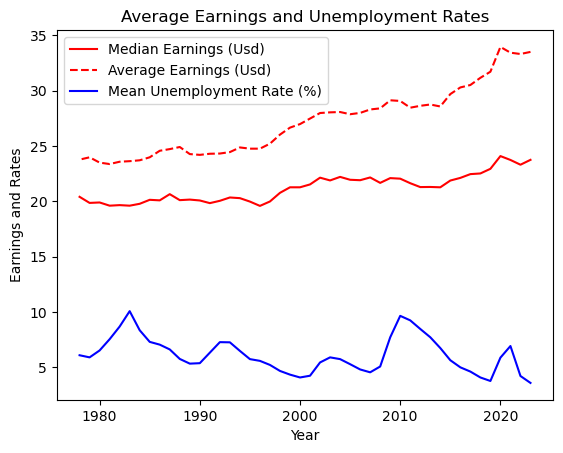

In [34]:
# Declaring data for plotting
x = df_economics['Year']
y1 = df_economics['Median (USD)']
y2 = df_economics['Average (USD)']
y3 = df_economics['All (%)']

# Creating lines
plt.plot(x, y1, label='Median Earnings (Usd)', color='red')
plt.plot(x, y2, label='Average Earnings (Usd)', color='red', linestyle='--')
plt.plot(x, y3, label='Mean Unemployment Rate (%)', color='blue')

# Adding titles
plt.title('Average Earnings and Unemployment Rates')
plt.xlabel('Year')
plt.ylabel('Earnings and Rates')

# Setting ticks and ranges
# TBD

# Adding a legend
plt.legend()

# Showing plot
plt.show()

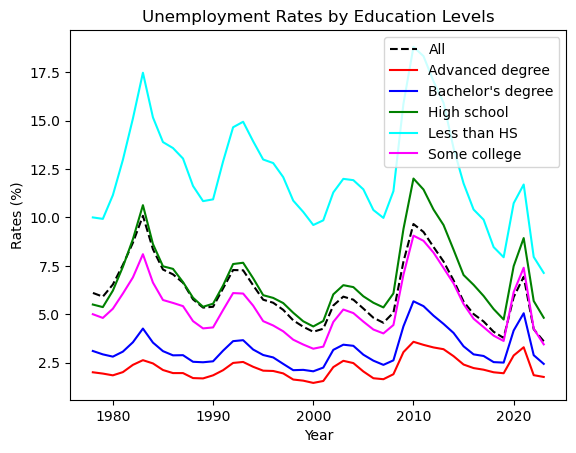

In [35]:
# Declaring data for plotting
x = df_economics['Year']
y1 = df_economics['All (%)']
y2 = df_economics['Advanced degree (%)']
y3 = df_economics["Bachelor's degree (%)"]
y4 = df_economics['High school (%)']
y5 = df_economics['Less than HS (%)']
y6 = df_economics['Some college (%)']

# Creating lines
plt.plot(x, y1, label='All', color='black', linestyle='--')
plt.plot(x, y2, label='Advanced degree', color='red')
plt.plot(x, y3, label="Bachelor's degree", color='blue')
plt.plot(x, y4, label='High school', color='green')
plt.plot(x, y5, label='Less than HS', color='cyan')
plt.plot(x, y6, label='Some college', color='magenta')

# Adding titles
plt.title('Unemployment Rates by Education Levels')
plt.xlabel('Year')
plt.ylabel('Rates (%)')

# Setting ticks and ranges
# TBD

# Adding a legend
plt.legend()

# Showing plot
plt.show()

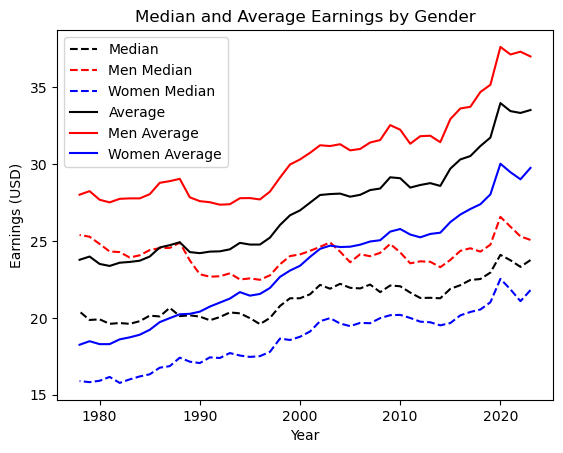

In [36]:
# Declaring data for plotting
x = df_economics['Year']
y1 = df_economics['Median (USD)']
y2 = df_economics['Men Median (USD)']
y3 = df_economics['Women Median (USD)']
y4 = df_economics['Average (USD)']
y5 = df_economics['Men Average (USD)']
y6 = df_economics['Women Average (USD)']

# Creating lines
plt.plot(x, y1, label='Median', color='black', linestyle='--')
plt.plot(x, y2, label='Men Median', color='red', linestyle='--')
plt.plot(x, y3, label='Women Median', color='blue', linestyle='--')
plt.plot(x, y4, label='Average', color='black')
plt.plot(x, y5, label='Men Average', color='red')
plt.plot(x, y6, label='Women Average', color='blue')

# Adding titles
plt.title('Median and Average Earnings by Gender')
plt.xlabel('Year')
plt.ylabel('Earnings (USD)')

# Setting ticks and ranges
# TBD

# Adding a legend
plt.legend()

# Showing plot
plt.show()